<a href="https://colab.research.google.com/github/estengeka/Bayes-Obsvn-GeoT/blob/main/Bayes_Obsvn_GeoT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Updating for Observational Method in Geotechnical Engineering

## Introduction

The observational method in geotechnical engineering involves monitoring performance during construction to adjust designs based on actual behavior, reducing conservatism and costs. Originated by Terzaghi and refined by Peck (1969), it allows for adaptive management in projects like foundations, slopes, and dams.

Bayesian updating enhances this by incorporating uncertainty probabilistically. It starts with prior distributions of soil parameters (e.g., from site investigations) and updates them to posteriors using new data (likelihood), via Bayes' theorem: P(θ|data) ∝ P(data|θ) * P(θ).

This integration addresses an unsolved challenge: lack of seamless, automated tools for real-time parameter updating during construction, leading to suboptimal risk management. Research value includes improved safety and efficiency in adaptive designs, e.g., for climate-resilient infrastructure.

Example scenario: Updating undrained shear strength (Su) of clay soil during pile foundation construction. Prior from initial borings: Su ~ Normal(50 kPa, 10 kPa). Sequential cone penetration test (CPT) data during installation provides observations, assumed ~ Normal(Su, 5 kPa noise). We update posteriors, compute P(Su < 40 kPa) for failure risk, and suggest adjustments if risk > 5%.

References: Tang (1979) on probabilistic observational method; Straub (2010) on Bayesian geotechnics.

In [ ]:
# Setup and Libraries
# Install required packages (PyMC and Arviz may not be pre-installed in Colab)
!pip install pymc arviz -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
from google.colab import files
import io
import ipywidgets as widgets
from IPython.display import display
from scipy.stats import norm  # For analytical checks, optional

# Set random seed for reproducibility
np.random.seed(42)

## Data Preparation

We simulate synthetic data for demonstration. Prior: Su ~ Normal(50, 10) kPa.

Observations: 10 sequential CPT measurements from a "true" Su=45 kPa with noise (std=5 kPa).

Data stored in Pandas DataFrame.

For real data: Upload a CSV with column 'observations' (one value per row).

In [ ]:
# Simulate prior samples (for visualization)
prior_samples = np.random.normal(50, 10, 1000)

# Simulate observational data
true_su = 45  # Hidden true value for simulation
num_observations = 10
observation_std = 5
observations = np.random.normal(true_su, observation_std, num_observations)

# Store in DataFrame
data_df = pd.DataFrame({'observations': observations})
print("Simulated Observations:")
print(data_df)

# Option for user-uploaded data (commented; uncomment to use)
# uploaded = files.upload()
# if uploaded:
#     data_df = pd.read_csv(io.BytesIO(uploaded[list(uploaded.keys())[0]]))
#     observations = data_df['observations'].values
#     num_observations = len(observations)
#     print("Uploaded Data Loaded.")

Simulated Observations:
   observations
0     51.996777
1     49.623168
2     45.298152
3     41.765316
4     48.491117
5     46.967427
6     49.475966
7     48.175859
8     50.247764
9     42.323824


## Bayesian Model Implementation

We use PyMC for hierarchical Bayesian modeling.

Model:
- Prior: Su ~ Normal(mu_prior, sigma_prior)
- Likelihood: obs[i] ~ Normal(Su, sigma_obs)

For sequential updating, we'll define a function to run MCMC on cumulative data.

Compute posterior samples, 95% HDI, and risk P(Su < 40).

Adaptive decision: If risk > 0.05, suggest adjustment.

In [ ]:
# Define a function for the Bayesian model
def bayesian_update_model(cumulative_obs, mu_prior=50, sigma_prior=10, sigma_obs=5):
    with pm.Model() as model:
        # Prior
        su = pm.Normal('su', mu=mu_prior, sigma=sigma_prior)

        # Likelihood
        obs = pm.Normal('obs', mu=su, sigma=sigma_obs, observed=cumulative_obs)

        # Sample posterior (MCMC)
        trace = pm.sample(1000, tune=500, return_inferencedata=True, progressbar=False)

    return trace

# Initial prior (no data)
initial_trace = bayesian_update_model([])  # Empty obs for prior only

## Sequential Updating Loop

Iteratively update with cumulative observations.

Collect posteriors and risks at each step.

In [ ]:
# Sequential updating
posterior_traces = [initial_trace]  # Start with prior
risks = []  # P(su < 40)
threshold = 40
risk_tolerance = 0.05

cumulative_obs = []
for i in range(num_observations):
    cumulative_obs.append(observations[i])
    trace = bayesian_update_model(np.array(cumulative_obs))
    posterior_traces.append(trace)

    # Compute risk
    su_samples = trace.posterior['su'].values.flatten()
    risk = np.mean(su_samples < threshold)
    risks.append(risk)

    # Adaptive decision
    if risk > risk_tolerance:
        print(f"After {i+1} observations: Risk = {risk:.3f} > {risk_tolerance}. Suggest design adjustment (e.g., add piles).")
    else:
        print(f"After {i+1} observations: Risk = {risk:.3f} <= {risk_tolerance}. Proceed.")

# Include initial risk from prior
initial_su_samples = initial_trace.posterior['su'].values.flatten()
initial_risk = np.mean(initial_su_samples < threshold)
risks.insert(0, initial_risk)
print(f"Initial Risk (Prior): {initial_risk:.3f}")

After 1 observations: Risk = 0.004 <= 0.05. Proceed.
After 2 observations: Risk = 0.000 <= 0.05. Proceed.
After 3 observations: Risk = 0.001 <= 0.05. Proceed.
After 4 observations: Risk = 0.003 <= 0.05. Proceed.
After 5 observations: Risk = 0.001 <= 0.05. Proceed.
After 6 observations: Risk = 0.001 <= 0.05. Proceed.
After 7 observations: Risk = 0.000 <= 0.05. Proceed.
After 8 observations: Risk = 0.000 <= 0.05. Proceed.
After 9 observations: Risk = 0.000 <= 0.05. Proceed.
After 10 observations: Risk = 0.000 <= 0.05. Proceed.
Initial Risk (Prior): 0.176


## Visualization and Analysis

Plot prior vs. posteriors.

Trace plots for last update.

Evolving risk plot.

Interactive: Vary number of observations with widget.

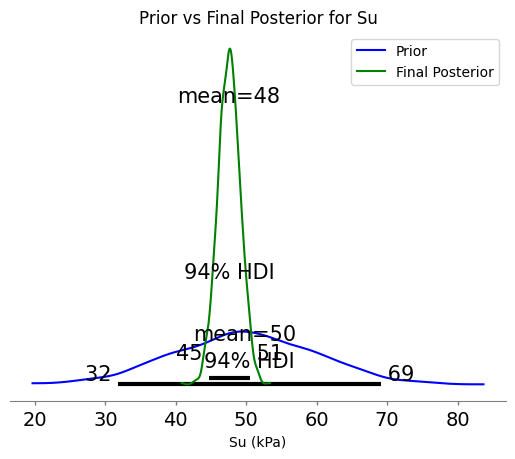

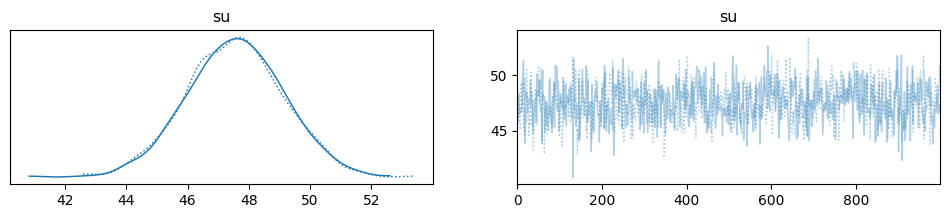

In [ ]:
# Plot prior vs final posterior
fig, ax = plt.subplots()
az.plot_posterior(initial_trace, var_names=['su'], ax=ax, color='blue', label='Prior')
az.plot_posterior(posterior_traces[-1], var_names=['su'], ax=ax, color='green', label='Final Posterior')
plt.title('Prior vs Final Posterior for Su')
plt.xlabel('Su (kPa)')
plt.show()

# Trace plot for final model (convergence check)
az.plot_trace(posterior_traces[-1], var_names=['su'])
plt.show()

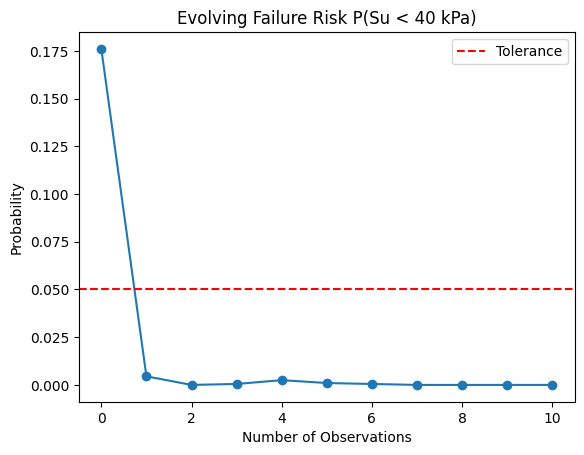

In [ ]:
# Evolving risk plot
plt.plot(range(len(risks)), risks, marker='o')
plt.axhline(risk_tolerance, color='red', linestyle='--', label='Tolerance')
plt.title('Evolving Failure Risk P(Su < 40 kPa)')
plt.xlabel('Number of Observations')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [ ]:
# Interactive: Vary number of observations
def plot_posterior_up_to(n_obs):
    if n_obs == 0:
        trace = initial_trace
    else:
        trace = posterior_traces[n_obs]

    az.plot_posterior(trace, var_names=['su'])
    plt.title(f'Posterior after {n_obs} Observations')
    plt.show()

    su_samples = trace.posterior['su'].values.flatten()
    risk = np.mean(su_samples < threshold)
    print(f"Risk: {risk:.3f}")

widgets.interact(plot_posterior_up_to, n_obs=(0, num_observations, 1));

interactive(children=(IntSlider(value=5, description='n_obs', max=10), Output()), _dom_classes=('widget-intera…

## Real-Time Simulation

Mimic real-time data stream with a loop (e.g., "receiving" data every few seconds).

In practice, integrate with IoT sensors via APIs (e.g., stream CPT data to Colab via Google Drive or external service).

In [ ]:
# Real-time simulation (loop with delays)
import time

# Reset for demo
cumulative_obs_rt = []
rt_trace = initial_trace
for i in range(num_observations):
    cumulative_obs_rt.append(observations[i])
    rt_trace = bayesian_update_model(np.array(cumulative_obs_rt))

    su_samples = rt_trace.posterior['su'].values.flatten()
    risk = np.mean(su_samples < threshold)
    print(f"Real-time Update {i+1}: Risk = {risk:.3f}")

    time.sleep(1)  # Simulate delay between measurements

Real-time Update 1: Risk = 0.006
Real-time Update 2: Risk = 0.001
Real-time Update 3: Risk = 0.001
Real-time Update 4: Risk = 0.003
Real-time Update 5: Risk = 0.001
Real-time Update 6: Risk = 0.000
Real-time Update 7: Risk = 0.000
Real-time Update 8: Risk = 0.000
Real-time Update 9: Risk = 0.000
Real-time Update 10: Risk = 0.000


## Extensions and Research Discussion

Extensions:
- Multi-parameter: Update Su, modulus, etc., with multivariate normals.
- Spatial variability: Incorporate Gaussian processes (via PyMC).
- FEM integration: Export posteriors to PLAXIS/ABAQUS via Python APIs for simulations.
- Large-scale: Use variational inference for speed on big data.

Limitations: MCMC slow for thousands of data points; switch to conjugate analytics for simples cases.

This prototypes real-time adaptive risk tools, addressing unsolved integration of observations with probabilistics—ideal for PhD research or conference (e.g., GeoRisk).

## Conclusions

This notebook demonstrates Bayesian updating in the observational method, enabling adaptive geotechnical designs. It shows sequential refinement of soil parameters and risk, paving the way for automated tools in construction monitoring.